Erstellt von: 4757202 und 4819233

Abschnitt 2: Neuronale Netzwerke

Erstellen Sie ein Convolutional Neural Network (CNN), dass auf Vorhersagen für Daten aus einem
gegebenen Datensatz angewendet werden kann.
Ziel ist es, ein möglichst leistungsfähiges CNN zu erstellen. Die Wahl der Hyperparameter des CNN ist
Teil der Aufgabe.
Dabei sind folgende Phasen in der Lösung zu berücksichtigen:
- Datenmanagement
- Modelldesign
- Training
- Validierung & Performancebewertung

Es gelten folgende Rahmenbedingungen:
- Verwenden Sie TensorFlow 2.3 / Keras.
- Die Programmiersprache ist Python.
- Abgabe als Datei im Python Notebook Format (.ipynb).
- Dokumentation und Erläuterungen sind im Python Notebook zu erstellen.
- Das Skript muss ohne Fehler in einer Google Colab Umgebung durchlaufen (evtl. auftretende
Warnungen sind zulässig).
- Der Quelltext muss sinnvoll dokumentiert sein.
- Bewerten Sie die Performance des von Ihnen erstellten Neuronalen Netzwerkes.
- Beschreiben Sie kurz die von Ihnen gewählte Architektur des Netzwerkes. Warum haben Sie die gewählten Komponenten gewählt?

# Laden des Datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Unser Versuch, das Modell weniger zufällig zu machen
seed = 2020

import os
os.environ['PYTHONHASHSEED']=str(seed)

import random
random.seed(seed)

np.random.seed(seed)
tf.random.set_seed(seed)

# Bibliotheken importieren
import tensorflow_datasets as tfds
from tensorflow_datasets.image_classification import horses_or_humans

# Datensatz laden für Übersicht
ds, ds_info = tfds.load("horses_or_humans", split='train', shuffle_files=True, with_info=True)
assert isinstance(ds, tf.data.Dataset)
print(ds_info)

tfds.as_dataframe(ds.take(10), ds_info)

# Trainingsdaten laden
X_train, y_train = tfds.as_numpy(tfds.load(
    'horses_or_humans',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
    shuffle_files=False,
))

# Testdaten laden
X_test, y_test = tfds.as_numpy(tfds.load(
    'horses_or_humans',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
    shuffle_files=False,
))

# Dimensionen der Test- und Trainingsdaten
print("Type und Shape der Trainingsdaten: " + str(type(X_train)), X_train.shape)
print("Type und Shape der Testdaten: " + str(type(X_test)), X_test.shape)

tfds.core.DatasetInfo(
    name='horses_or_humans',
    version=3.0.0,
    description='A large set of images of horses and humans.',
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=1283,
    splits={
        'test': 256,
        'train': 1027,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
    redistribution_info=,
)

Type und Shape der Trainingsdaten: <class 'numpy.ndarray'> (1027, 300, 300, 3)
Type und Shape der Testdaten: <class 'numpy.ndarray'> (256, 300, 300, 3)


Es existieren 1027 Trainingsbilder und 256 Testbilder mit der Größe 300x300 Pixel. Da es sich um Farbbilder handelt, exisiteren 3 weitere Dimensionen mit den RGB-Werten. 

# Datenmanagement

In [ ]:
# Sicherstellen, dass Trainings und Testdaten die gleiche Dimension haben
assert X_train.shape[1:] == X_test.shape[1:] # Die Batch Dimension wird ignoriert

In [ ]:
# Prüfe wieviele Label/Klassen in der Aufgabe vorkommen 
print(np.unique(y_train))

# Bestimme die Anzahl der Knoten im Ausgabelayer
num_classes = len(np.unique(y_train))
print(num_classes)

[0 1]
2


In [ ]:
# Array ansehen (Aufgrund der Lesbarkeit wurde der Befehl auskommentiert)
# print(X_train[0])

In [ ]:
# Shape aller Daten ausgeben
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1027, 300, 300, 3)
(1027,)
(256, 300, 300, 3)
(256,)


In [ ]:
# Selbsterklärende Labels vergeben
labels = ['horses', 'humans']

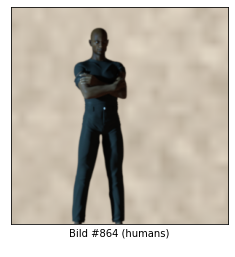

In [ ]:
# Zufallsbild aus den Trainingsdaten ausgeben
rnd_image = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[rnd_image])
plt.xticks([])
plt.yticks([])
plt.xlabel("Bild #%d (%s)\n" % (rnd_image, labels[y_train[rnd_image]]))
plt.show()

In [ ]:
# Lade Bibliothek zum Skalieren
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Multipliziere alle Werte mit 1/255 um Werte zwischen 0 und 1 zu erhalten
X_train = Rescaling(scale=1./255)(X_train)
X_test = Rescaling(scale=1./255)(X_test)

In [ ]:
# Lade Bibliothek zum Kippen des Bildes
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip

# Führe Transformation aus
X_train = RandomFlip(mode='horizontal', seed=seed)(X_train)
X_test = RandomFlip(mode='horizontal', seed=seed)(X_test)

# X_train = RandomFlip(mode='vertical', seed=seed)(X_train)
# X_test = RandomFlip(mode='vertical', seed=seed)(X_test)

Zuletzt wenden wir RandomFlip an, um die Bilder zufällig spiegeln zu lassen. Dadurch wird Überanpassung durch zu ähnliche Bilder verhindert und die Vielfalt der Daten erhöht.

Wir haben zusätzlich versucht, die Bilder durch den ImageDataGenerator variabler zu machen und somit einer Überanpassung durch die geringe Datenmenge vorzubeugen, jedoch konnten wir auch nach vielen Tests dadurch keine besseren Ergebnisse hervorbringen. Daher haben wir uns gegen dieses Verfahren entschieden.

# Modelldesign

In [ ]:
# Modell initialisieren
model = tf.keras.models.Sequential([
                                    
    # Inputshape: Bild mit 300x300 Pixeln und 3 Bytes für die Farbe
    # Erster Convolutionlayer mit 16 Filtern
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Zweiter Convolutionlayer mit 32 Filtern
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Dritter Convolutionlayer mit 64 Filtern
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Vierter Convolutionlayer mit 64 Filtern
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Fünfter Convolutionlayer mit 64 Filtern
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Sechster Convolutionlayer mit 256 Filtern 
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Tranformation 2D -> 1D
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    # Klassifikation
    # FC Layer 1
    tf.keras.layers.Dense(512, activation='relu'),

    # FC Layer 2
    tf.keras.layers.Dense(32, activation='relu'),

    # Output Layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Wir haben uns für das sequenzielle Modell mit sechs Convolutional Layern entschieden. Wir beginnen mit low-level Filtern und steigern uns hoch während die Bilder durch die Max-Pooling Layer immer kleiner werden. Für die vielen Convolutional Layer haben wir uns entschieden, weil durch diese beim Testen die Überanpassung reduziert werden konnte. Die Max-Pooling Layer haben wir verwendet, um die Größe des Inputs zu reduzieren.

Anschließend wird unser mehrdimensionales Bild in einen einzelnen Vektor umgewandelt. Mit dem eindimensionalen Layer kann nun gearbeitet werden.

Der Dropout-Layer hilft uns dabei, dass unser Modell nicht überangepasst wird, denn dadurch werden zufällig Verknüpfungen beim Training ignoriert.

Danach verwenden wir zwei Fully-Connected Layer, um die Neuronen zu verknüpfen. Dies funktioniert nur mit dem zuvor verwendeten Flatten Layer.

Der Output-Layer wird zuletzt mit der Sigmoid-Funktion aktiviert. So erhalten wir am Ende eine Zahl zwischen 0 und 1, welche den Output bestimmt. Hierbei steht 0 für Pferd und 1 für Mensch.

In [ ]:
# Optimizer importieren
from tensorflow.keras.optimizers import RMSprop

# Model kompilieren 
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.00005),
              metrics=['accuracy'])

Als Loss-Funktion wurde 'binary_crossentropy' gewählt, da es sich um eine binäre Klassifikation handelt. Der Optimizer RMSprop wurde gewählt, da die Lernrate angepasst werden kann. Die niedrige Lernrate von 0.00005 wurde durch ausprobieren gefunden und gewählt, um nicht zu overfitten.

In [ ]:
# Modelübersicht
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 33, 33, 64)      

Unser Modell besitzt ca. 800.000 trainierbare Parameter.

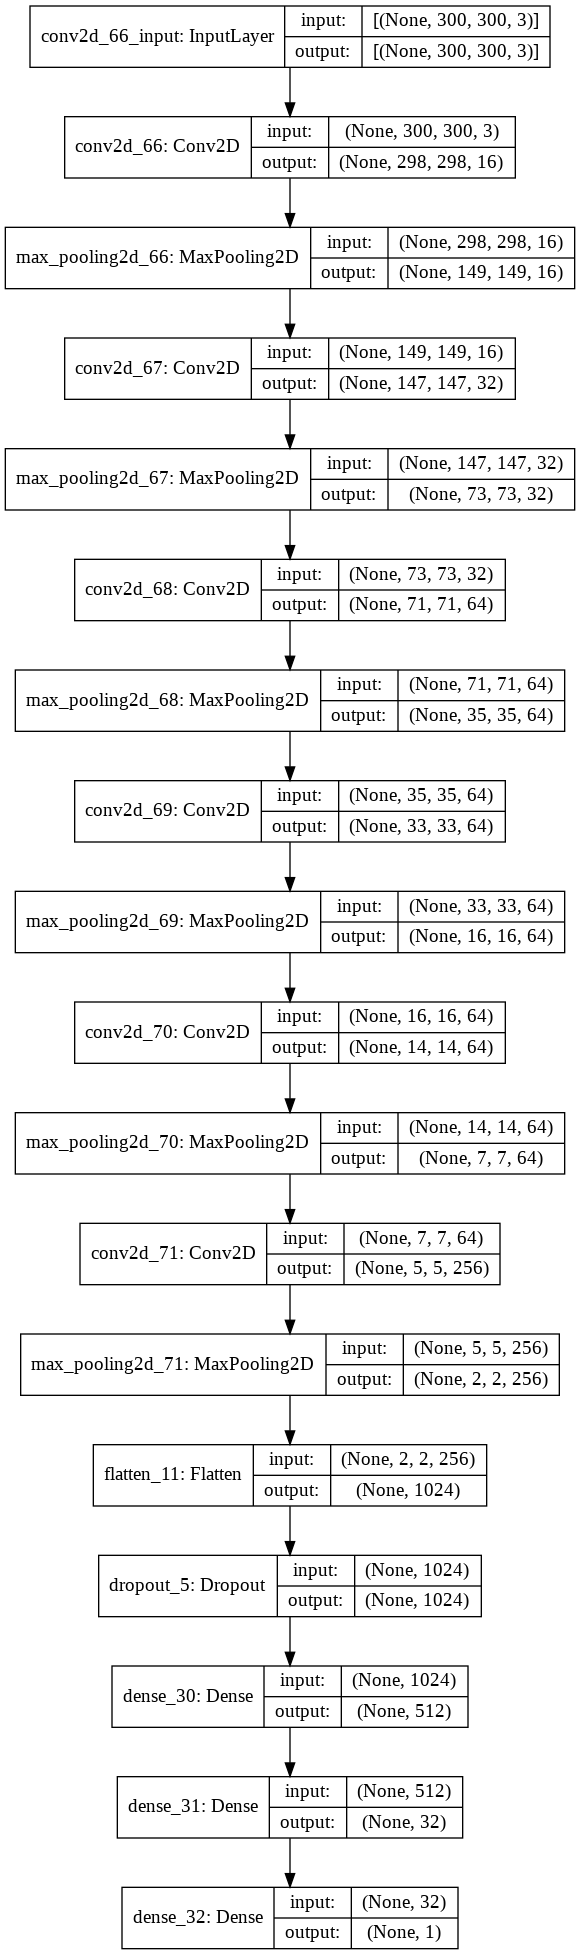

In [ ]:
# Modell als Bild ausgeben
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# Training

In [ ]:
epochs = 13
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=epochs, steps_per_epoch=8, validation_steps=2, verbose=1)

Epoch 1/13
8/8 [==============================] - 3s 250ms/step - loss: 0.6896 - accuracy: 0.5108 - val_loss: 0.6812 - val_accuracy: 0.5000
Epoch 2/13
8/8 [==============================] - 2s 226ms/step - loss: 0.6734 - accuracy: 0.5927 - val_loss: 0.6749 - val_accuracy: 0.5000
Epoch 3/13
8/8 [==============================] - 2s 205ms/step - loss: 0.6716 - accuracy: 0.5529 - val_loss: 0.6644 - val_accuracy: 0.5039
Epoch 4/13
8/8 [==============================] - 2s 241ms/step - loss: 0.6633 - accuracy: 0.5888 - val_loss: 0.6499 - val_accuracy: 0.6367
Epoch 5/13
8/8 [==============================] - 2s 197ms/step - loss: 0.6463 - accuracy: 0.6695 - val_loss: 0.6410 - val_accuracy: 0.5078
Epoch 6/13
8/8 [==============================] - 2s 204ms/step - loss: 0.6291 - accuracy: 0.6593 - val_loss: 0.6267 - val_accuracy: 0.5234
Epoch 7/13
8/8 [==============================] - 2s 200ms/step - loss: 0.6060 - accuracy: 0.7226 - val_loss: 0.6031 - val_accuracy: 0.6016
Epoch 8/13
8/8 [====

Wir haben uns für 13 Epochen entschieden, da die validation accuracy mit weiteren Epochen nicht besser wurde, sondern stagniert hat. Nach 13 Epochen ist das Modell nicht überangepasst.

Für die Batch-Size von 128 haben wir uns durch viele Probedurchläufe mit verschiedenen Batch-Sizes entschieden.

# Validierung & Performancebewertung

In [ ]:
# Model verifizieren auf Testdaten
model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 21ms/step - loss: 0.4293 - accuracy: 0.8359


[0.42929786443710327, 0.8359375]

In [ ]:
# Werte anzeigen
print(history.history['accuracy'])
print(history.history['val_accuracy'])

[0.515625, 0.5150166749954224, 0.538375973701477, 0.6129032373428345, 0.6384872198104858, 0.6395995616912842, 0.7508342862129211, 0.7319243550300598, 0.767519474029541, 0.779296875, 0.8086763024330139, 0.8142380714416504, 0.8064516186714172]
[0.5, 0.5, 0.50390625, 0.63671875, 0.5078125, 0.5234375, 0.6015625, 0.58984375, 0.671875, 0.87890625, 0.91796875, 0.8359375, 0.8359375]


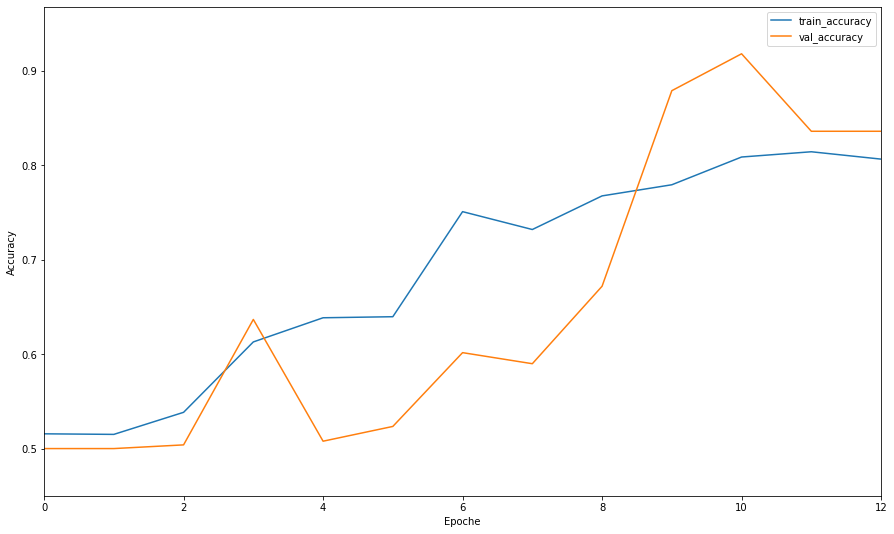

In [ ]:
# Verläufe zeichnen
plt.figure(figsize=(15,9))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.ylim((min(min(history.history['accuracy']), min(history.history['val_accuracy']))) - 0.05,
          (max(max(history.history['accuracy']), max(history.history['val_accuracy']))) + 0.05)
plt.xlim(0,epochs-1)
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.axhline(1, color='red')
plt.legend()

Die Accuracy beim Training und bei der Validation steigen ähnlich an. Beim Ausprobieren hatten wir immer die Schwierigkeit, dass die validation accuracy selbst mit gleichen Hyperparametern von Durchlauf zu Durchlauf sehr geschwankt hat. Dadurch waren unsere Modelle unzuverlässig. Wir haben versucht, durch das Setzen von Seeds den Zufall zu "beeinflussen", doch es kam dennoch zu Schwankungen. 

Unser jetztiges Modell ist deutlich konstanter geworden als zuvor. Erreicht haben wir dies durch viel rumprobieren.

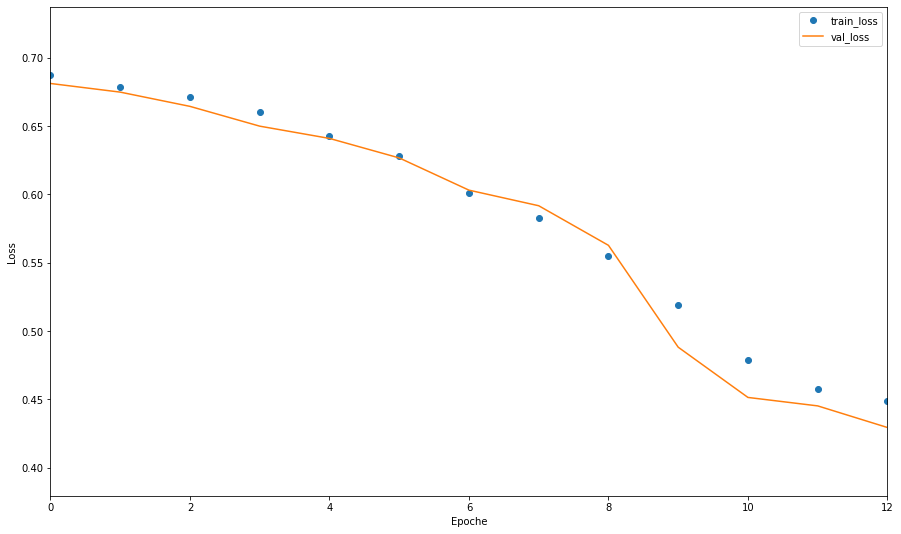

In [ ]:
# Loss-history plotten
plt.figure(figsize=(15,9))
plt.plot(history.history['loss'], 'o', label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylim((min(min(history.history['loss']), min(history.history['val_loss']))) - 0.05,
          (max(max(history.history['loss']), max(history.history['val_loss']))) + 0.05)
plt.xlim(0,epochs-1)
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

Unser Trainings- und Validationloss fällt gleichzeitig ab und unterscheidet sich nur marginal. Das ist in unseren Augen ein gutes Zeichen dafür, dass unser Modell weder überangepasst noch unterangepasst ist. 

Wert: [0.8410988]
Prediction: #136 is a human


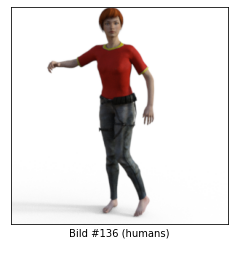

In [ ]:
# Zufallsbild mit Vorhersage ausgeben
rnd_image = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[rnd_image])
plt.xticks([])
plt.yticks([])
plt.xlabel("Bild #%d (%s)\n" % (rnd_image, labels[y_test[rnd_image]]))

list(X_test)
classes = model.predict(X_test, batch_size=10)
print("Wert: " + str(classes[rnd_image]))
if classes[rnd_image]>0.5:
  print("Prediction: #" + str(rnd_image) + " is a human")
else:
  print("Prediction: #" + str(rnd_image) + " is a horse")


In [ ]:
# Review der Testdaten
list(X_test)
classes = model.predict(X_test, batch_size=10)
x = 0
horse = 0
total_horses = 0
human = 0
total_humans = 0
for label in y_test:

  if classes[x]>0.5 and labels[y_test[x]] == 'humans':
    human += 1
  elif classes[x]<0.5 and labels[y_test[x]] == 'horses':
    horse += 1
  if labels[y_test[x]] == 'horses':
    total_horses += 1
  else:
    total_humans += 1
  x = x + 1

print("Von "+ str(total_horses) + " Pferden wurden " + str(horse) + " Pferde richtig vorhergesagt.")
print("Von "+ str(total_humans) + " Menschen wurden " + str(human) + " Menschen richtig vorhergesagt.")

Von 128 Pferden wurden 86 Pferde richtig vorhergesagt.
Von 128 Menschen wurden 128 Menschen richtig vorhergesagt.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


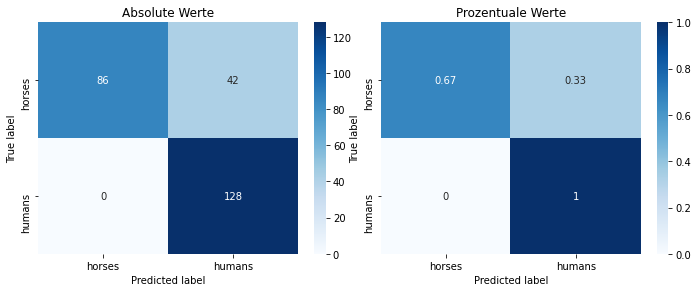

In [ ]:
# Lade Bibliotheken
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

y_pred=model.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test ,predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat,
                     index = labels, 
                     columns = labels)

con_mat_df_norm = pd.DataFrame(con_mat_norm,
                     index = labels, 
                     columns = labels)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, fmt='d', ax=ax1)
plt.tight_layout()
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')

sns.heatmap(con_mat_df_norm, annot=True,cmap=plt.cm.Blues, ax=ax2)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax1.set_title("Absolute Werte")
ax2.set_title("Prozentuale Werte")
plt.show()


Unser Modell hat 128 von 128 Menschen korrekt vorhergesagt. Allerdings konnte es nur 86 von 128 Pferden korrekt vorhersagen, was in etwa 67% entspricht. Pferde wurden meistens dann als Menschen vorhergesagt, wenn beispielsweise nicht alle 4 Beine zu sehen waren oder die Perspektive sehr ungewöhnlich gewählt war. Alles in allem besitzt unser Modell eine Accuracy von etwa 84%, was deutlich besser als Raten ist.

---

In fast allen unserer Testdurchläufe hatte das Modell Schwierigkeiten damit, einige Pferdebilder richtig zu erkennen. Bei diesen Bildern hat es sich meistens um Bilder von vorne oder hinten gehandelt, sodass die wesentlichen Merkmale wie beispielsweise die 4 Beine eines Pferdes nicht richtig erkannt werden konnten. 

Menschen wurden vom Modell stets korrekt klassifiziert. Es wurde fast nie ein Mensch als Pferd vorhergesagt, sondern immer nur anders herum.

Das Modell könnte durch ein Training mit mehr und vielfältigeren Bildern weiter verbessert werden.